In [32]:
from utils.utils import join, my_load
import os
import numpy as np
import torch

import utils.visualisation as viz

from matplotlib.colors import TABLEAU_COLORS
import utils.utils as utils
import warnings

from utils.constants import CIFAR10_ROBUST_MODELS, IMAGENET_ROBUST_MODELS, \
    CIFAR10_NAIVE_MODELS, IMAGENET_NAIVE_MODELS, \
    cifar10_model_dict, imagenet_model_dict
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

import seaborn as sns
import pandas as pd
from plot_results import get_paths, get_results, fix_values, COLORS, ALL_MARKERS

In [72]:
def plot_violin_all(paths, figsize=(7, 16), figname='violin_plot'):
    """
    Plot calibration and histogram all in one single plot.
    """

    save_path = "figures/violin_plots/"
    if not os.path.isdir(save_path):
        os.makedirs(save_path)

    fig, axs = viz.create_figure(1, 1, figsize=figsize, squeeze=True, fontsize=30)

    model_name_list = []
    models_avg_entropy = {}

    extend = 0.2 # Di quanto allungare il segmento
    linewidth = 4
    marksize= 10
    
    data = {'entropies': [], 'atk_type': "", "model_name":""}
    df = pd.DataFrame.from_dict(data)

    
    for plot_i, path in enumerate(paths):
        path_splitted = path.split('/')
        eps_to_adv_results_dict = get_results(*path_splitted)

        model_name = path_splitted[path_splitted.index('None') + (1 if not 'naive' in path else -1)]
        model_name_list.append(f"I{plot_i+1}" if 'imagenet' in path else f"C{plot_i+1}")


        clean_entropies = eps_to_adv_results_dict[0]['entropy_of_mean']
        oatk_entropies = fix_values(path,'entropy_of_mean', 'Stab')
        uatk_entropies = fix_values(path,'entropy_of_mean', 'Shake')

        models_avg_entropy[model_name] = {"clean":clean_entropies.mean().item(),
                                          "oatk":oatk_entropies.mean().item(),
                                          "uatk":uatk_entropies.mean().item()}

        data1 = {'entropies': clean_entropies, 'atk_type': "Clean", "model_name":model_name_list[plot_i]}
        data2 = {'entropies': oatk_entropies, 'atk_type': "Over", "model_name":model_name_list[plot_i]}
        data3 = {'entropies': uatk_entropies, 'atk_type': "Under", "model_name":model_name_list[plot_i]}
        
        df = pd.concat([df,pd.DataFrame.from_dict(data1),pd.DataFrame.from_dict(data2),pd.DataFrame.from_dict(data3)])
    
    # print(df)
    
    axs= sns.violinplot(data=df, x="model_name", y="entropies", hue="atk_type",
               split=True,  fill=False, inner="quart")
        

    # 
    # # LEGEND
    # legend_lines = [ Line2D([0], [0], color=COLORS[i], marker=ALL_MARKERS[i], ms=linewidth*3, lw=linewidth) for i in range(3)]
    # labels = ["Clean", "Over", "Under"]
    # 
    # fig.legend(legend_lines, labels, loc='upper center', ncols=3, frameon=False, bbox_to_anchor=(0.5, 1.05))

    axs.grid('on')
    # fig.suptitle(figname)
    fig.tight_layout()

    fig.show()
    fig.savefig(f"{save_path}{figname}.pdf", bbox_inches='tight') 
    # utils.my_save(models_avg_entropy, f"{save_path}{figname}.pkl")


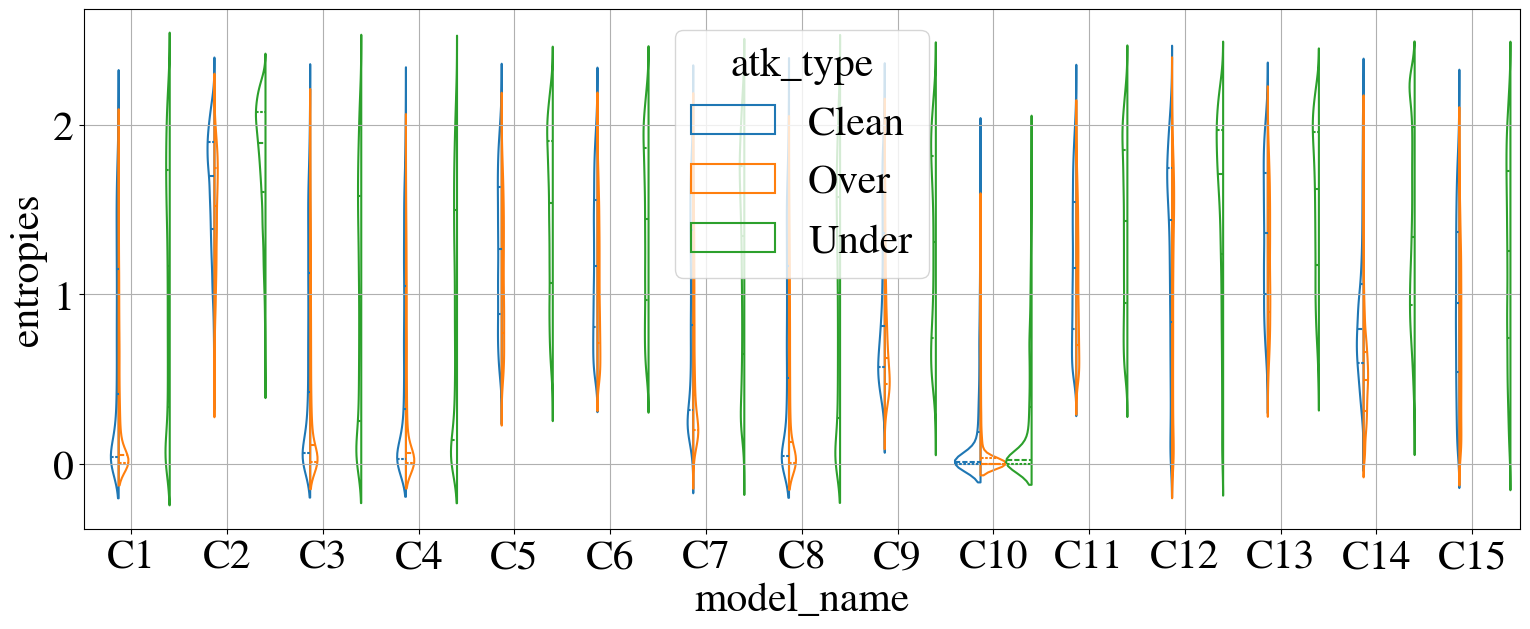

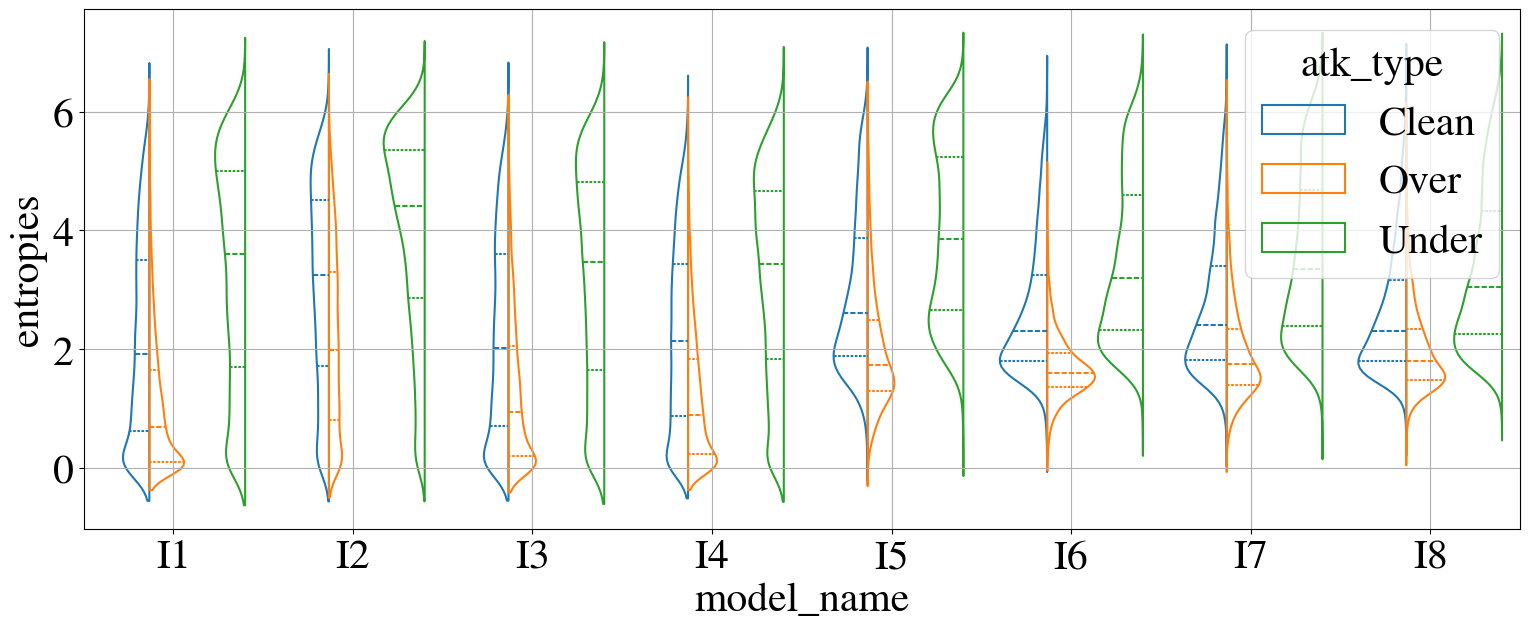

In [73]:
atk_type_and_name_list = ['O-atk/Stab', "O-atk/AutoTarget",  'U-atk/Shake']
datasets = ["cifar10","imagenet"]
robusts = [True]

dict_terms = {'semi_robust': 'robust',
              'naive_robust': 'naive'}

# PATHS STRUCTURE: 0-C10 stab, 1-IMG stab, 2-C10 AT, 3-IMG AT, 4-C10 shake, 5-IMG shake
paths = get_paths(datasets, atk_type_and_name_list, robusts, verbose=False)

for path_list in paths[:2]:
    robustness_level = dict_terms[path_list[0].split('/')[2]]
    ds_name = path_list[0].split('/')[3]
    title = f"SNS_violinplots_{robustness_level}_{ds_name}"
    #plot_violin_single(path_list, ds=ds_name, figtitle=title)
    plot_violin_all(path_list, figname=title)